# Тестовое задание. Демографические данные о покупателях гипермаркета в Сан-Франциско

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']= (12,8)

In [3]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

### Подготовка таблицы с расшифровкой уровней признаков

In [4]:
# Составление таблицы категорий признаков df_annot
with open('data/marketing.info.txt', 'r') as f:
    # Отбор строк, которые касаются описания категорий
    input_txt = f.readlines()[20:135]
i = 0
df_annot = pd.DataFrame()
while i<len(input_txt):
    line = input_txt[i]
    if not line.strip():
        i += 1
        continue
    # Формирование имени признака
    refined_line = line.lstrip(' 1234567890').rstrip()
    current_dict = {}
    i += 1
    while input_txt[i].strip():
        line = input_txt[i]
        # Формирование уровней признака (до точки - код, после - наименование)
        current_dict[int(line.split('.')[0].strip())] = line.split('.')[1].strip()
        i += 1
    df_annot[refined_line] = pd.Series(current_dict)

### Загрузка и "первый взгляд" на датасет

In [86]:
df_cols = [
    'ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)',
    'SEX',
    'MARITAL STATUS',
    'AGE',
    'EDUCATION',
    'OCCUPATION',
    'HOW LONG HAVE YOU LIVED IN THE SAN FRAN./OAKLAND/SAN JOSE AREA?',
    'DUAL INCOMES (IF MARRIED)',
    'PERSONS IN YOUR HOUSEHOLD',
    'PERSONS IN HOUSEHOLD UNDER 18',
    'HOUSEHOLDER STATUS',
    'TYPE OF HOME',
    'ETHNIC CLASSIFICATION',
    'WHAT LANGUAGE IS SPOKEN MOST OFTEN IN YOUR HOME?'
]
df = pd.read_csv('data/marketing.data', sep=' ', names=df_cols)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993 entries, 0 to 8992
Data columns (total 14 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)           8993 non-null   int64  
 1   SEX                                                              8993 non-null   int64  
 2   MARITAL STATUS                                                   8833 non-null   float64
 3   AGE                                                              8993 non-null   int64  
 4   EDUCATION                                                        8907 non-null   float64
 5   OCCUPATION                                                       8857 non-null   float64
 6   HOW LONG HAVE YOU LIVED IN THE SAN FRAN./OAKLAND/SAN JOSE AREA?  8080 non-null   float64
 7   DUAL INCOMES (IF MARRIED)                 

In [7]:
df.isna().sum() / len(df)

ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)             0.000000
SEX                                                                0.000000
MARITAL STATUS                                                     0.017792
AGE                                                                0.000000
EDUCATION                                                          0.009563
OCCUPATION                                                         0.015123
HOW LONG HAVE YOU LIVED IN THE SAN FRAN./OAKLAND/SAN JOSE AREA?    0.101523
DUAL INCOMES (IF MARRIED)                                          0.000000
PERSONS IN YOUR HOUSEHOLD                                          0.041699
PERSONS IN HOUSEHOLD UNDER 18                                      0.000000
HOUSEHOLDER STATUS                                                 0.026687
TYPE OF HOME                                                       0.039698
ETHNIC CLASSIFICATION                                              0.007561
WHAT LANGUAG

В датасете имеются пропущенные значения. Но доля пропущенных значений от столбца к столбцу почти не превышает 5% (только в ответе на вопрос "сколько времени проживаете на этой территории" - 10% пустых значений).

Все признаки в датасете - категориальные и в перекодированном виде. На части из них задано отношение "порядка".

In [8]:
# Категориальные признаки
categorical_cols = [
    'SEX',
    'MARITAL STATUS',
    'OCCUPATION',
    'DUAL INCOMES (IF MARRIED)',
    'HOUSEHOLDER STATUS',
    'TYPE OF HOME',
    'ETHNIC CLASSIFICATION',
    'WHAT LANGUAGE IS SPOKEN MOST OFTEN IN YOUR HOME?'
]
# Порядковые признаки
ordinal_cols = [
    'ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)',
    'AGE',
    'EDUCATION',
    'HOW LONG HAVE YOU LIVED IN THE SAN FRAN./OAKLAND/SAN JOSE AREA?',
    'PERSONS IN YOUR HOUSEHOLD',
    'PERSONS IN HOUSEHOLD UNDER 18'
]

Исходный датасет в незакодированном виде:

In [9]:
df_labelled = df.copy()
for col in df.columns:
    df_labelled[col+'_'] = df[col].map(df_annot[col].to_dict())

## EDA

По условиям задачи необходимо спрогнозировать:
 - Уровень дохода по ответам на остальные 13 вопросов
 - Род занятости по ответам на остальные 13 вопросов

In [10]:
target_features = [
    'ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)',
    'OCCUPATION'
]

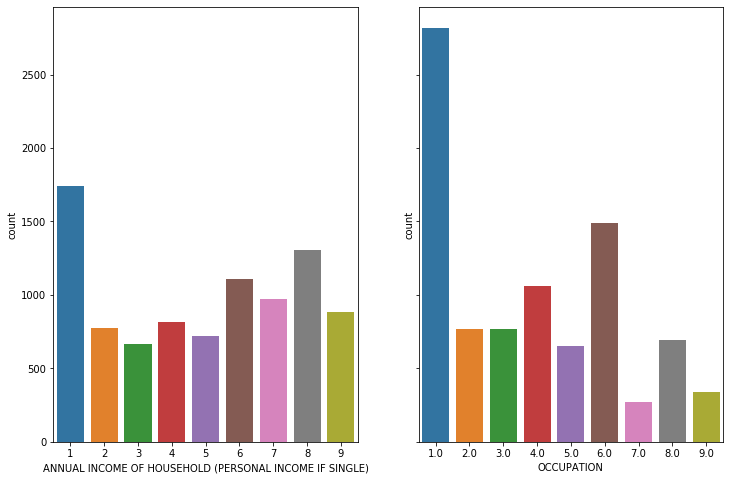

In [11]:
fig, (ax0, ax1) = plt.subplots(1,2, sharey=True)
sns.countplot(x=target_features[0], data=df, ax=ax0);
sns.countplot(x=target_features[1], data=df, ax=ax1);

- Респонденты распределены относительно равноверно по уровню дохода. Особенно если исключить из выборки подростков (см. график ниже).
- При прогнозировании рода занятости придётся столкнуться с несбалансированностью классов. Число специалистов/менеджеров заметно превалирует над количеством людей в остальных группах.

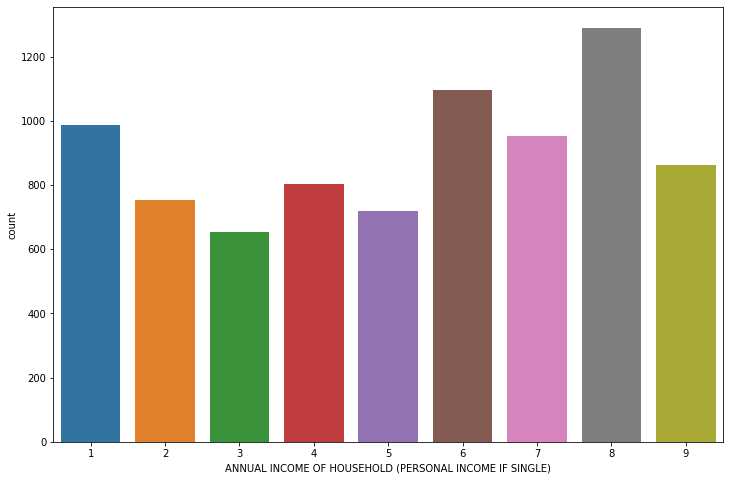

In [12]:
sns.countplot(x=target_features[0], data=df[df['AGE']>1]);

Связь между целевыми переменными есть, поэтому их соответственно можно использовать как зависимые переменные.

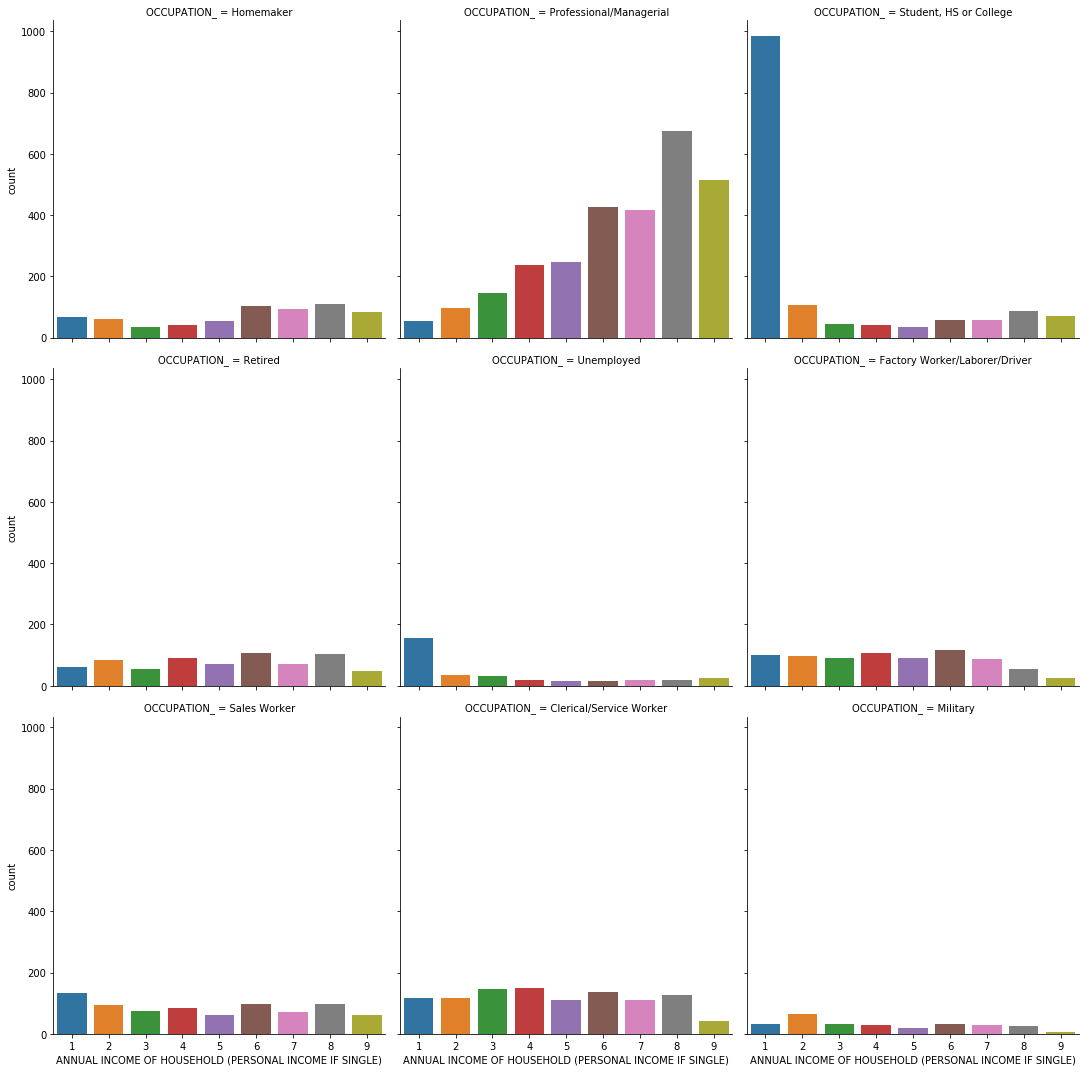

In [13]:
sns.catplot('ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)', col='OCCUPATION_', data=df_labelled, col_wrap=3, kind="count");

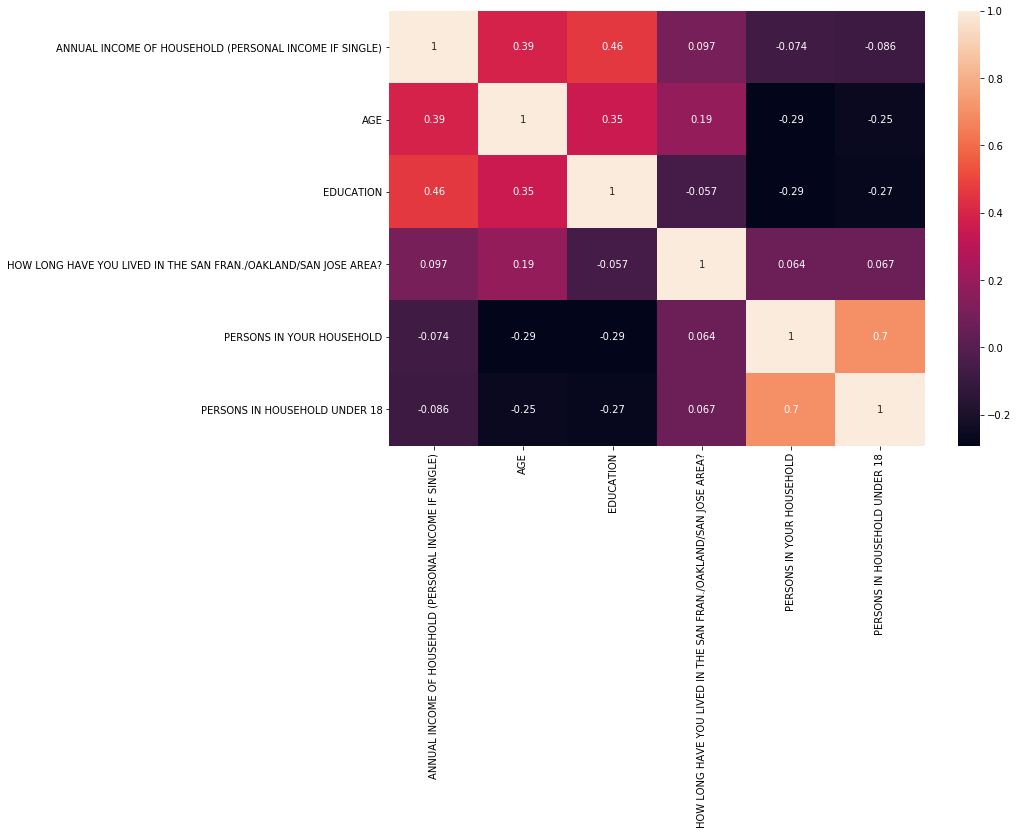

In [14]:
sns.heatmap(df[ordinal_cols].corr(), annot=True);

Корреляция переменной доход с остальными, в том числе и категориальными:

In [15]:
df.corr()['ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)'].sort_values()

HOUSEHOLDER STATUS                                                -0.518421
MARITAL STATUS                                                    -0.482685
OCCUPATION                                                        -0.361461
TYPE OF HOME                                                      -0.209666
WHAT LANGUAGE IS SPOKEN MOST OFTEN IN YOUR HOME?                  -0.104551
PERSONS IN HOUSEHOLD UNDER 18                                     -0.086430
PERSONS IN YOUR HOUSEHOLD                                         -0.073729
SEX                                                               -0.038720
HOW LONG HAVE YOU LIVED IN THE SAN FRAN./OAKLAND/SAN JOSE AREA?    0.097300
ETHNIC CLASSIFICATION                                              0.109450
DUAL INCOMES (IF MARRIED)                                          0.367962
AGE                                                                0.391473
EDUCATION                                                          0.461601
ANNUAL INCOM

Высокая корреляция между доходом и некоторыми категориальными переменными связана с тем, что для некоторых переменных условно задан "порядок" с точки зрения дохода.

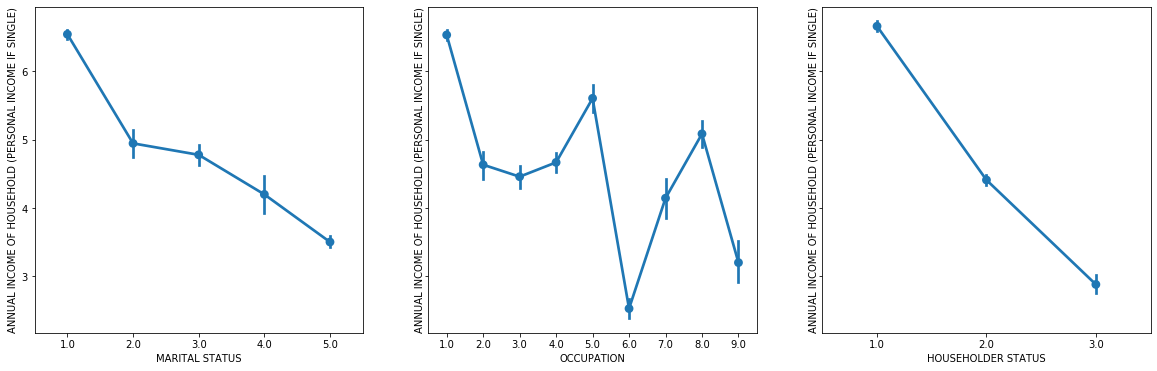

In [17]:
fig, axs = plt.subplots(1,3, sharey=True)
plt.rcParams['figure.figsize']= (20,6)
cat_cols_with_corr = [
    'MARITAL STATUS',
    'OCCUPATION',
    'HOUSEHOLDER STATUS',
]
for i in range(3):
    sns.pointplot(x=cat_cols_with_corr[i],y="ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)",
                  data=df, ax=axs[i]);

Между доходом и возрастом проявляется "квадратичная зависимость":

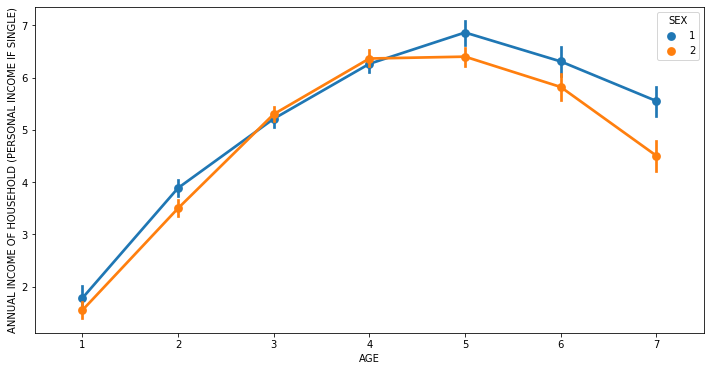

In [18]:
plt.rcParams['figure.figsize']= (12,6)
sns.pointplot(x="AGE", y="ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)", 
              hue="SEX", data=df);

### Информация "для владельцев гипермаркета"

Среди клиентов магазина женщин преобладают "замужние", а среди мужчин - холостые. Эту информацию потенциально можно использовать для "таргетирования" клиентов.

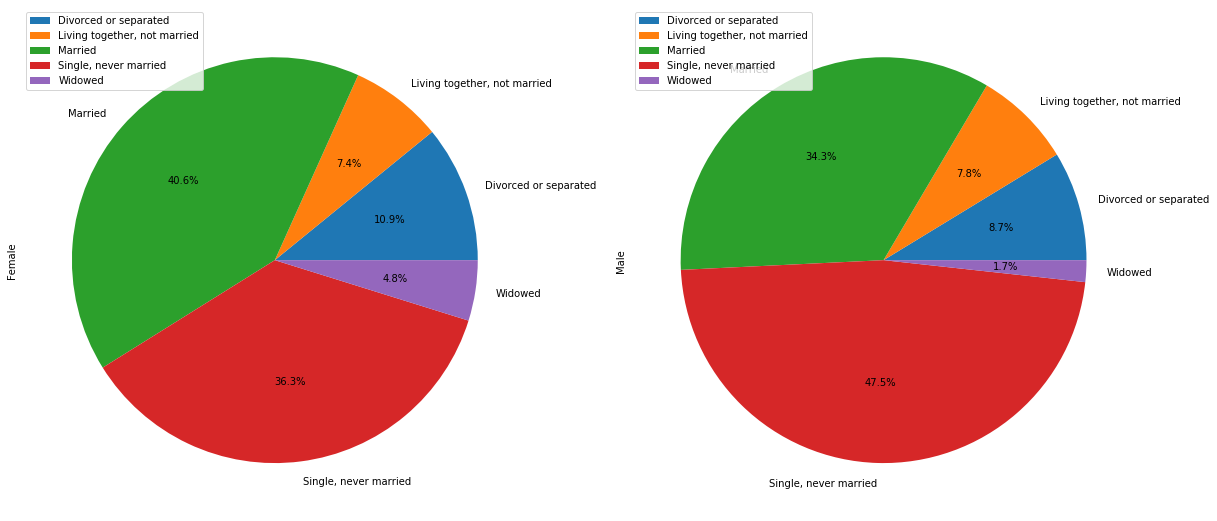

In [19]:
pd.crosstab(df_labelled['MARITAL STATUS_'], df_labelled['SEX_'], 
            normalize='columns').plot.pie(subplots=True, autopct='%1.1f%%',
                                          figsize=(20,10));

Среди семей, говорящих по-испански, чаще встречаются многодетные семьи. Для определенных групп товаров может быть полезно "дублирование" на испанском языке.

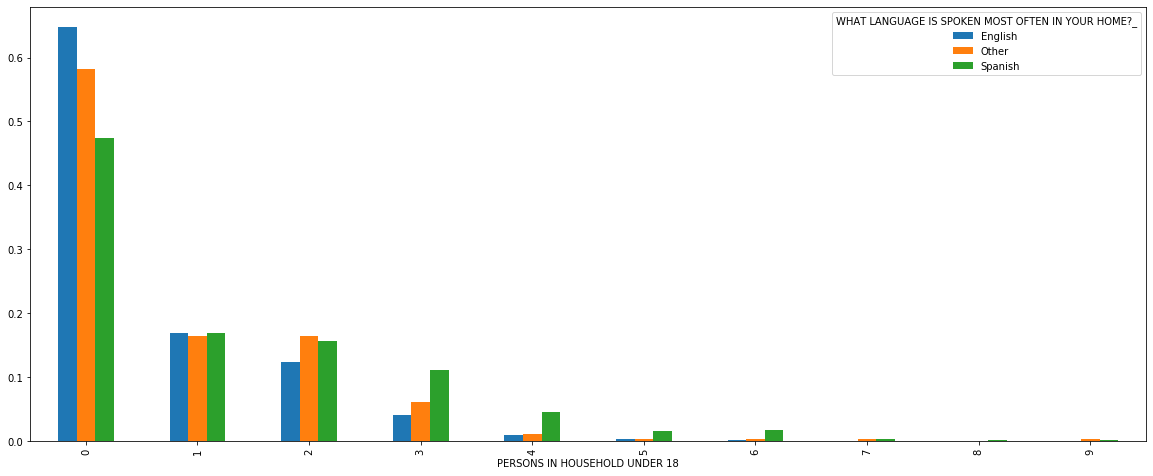

In [20]:
pd.crosstab(df_labelled['PERSONS IN HOUSEHOLD UNDER 18'], 
            df_labelled['WHAT LANGUAGE IS SPOKEN MOST OFTEN IN YOUR HOME?_'], 
            normalize='columns').plot.bar(figsize=(20,8));

## Моделирование

По условиям задачи необходимо спрогнозировать:
 - Уровень дохода по ответам на остальные 13 вопросов
 - Род занятости по ответам на остальные 13 вопросов

### Прогнозирование уровня дохода

Целевая переменная (уровень дохода) - порядковая, прогнозирование уровня дохода рассматривается как задача регрессии.

In [21]:
target_feature = 'ANNUAL INCOME OF HOUSEHOLD (PERSONAL INCOME IF SINGLE)'

Корреляция между уровнем дохода и сроком проживания на территории минимальна и этот признак имеет наибольшее число пропусков, поэтому принято решение убрать этот фактор.
Остальные пропущенные значения исключены.

In [87]:
df['PERSONS IN YOUR HOUSEHOLD'] = df.groupby('PERSONS IN HOUSEHOLD UNDER 18')['PERSONS IN YOUR HOUSEHOLD']\
                                                .transform(lambda x: x.fillna(x.mean()))

df_cleared = df.drop(['HOW LONG HAVE YOU LIVED IN THE SAN FRAN./OAKLAND/SAN JOSE AREA?'], axis=1).dropna()

Все категориальные переменные перекодированы в бинарные

In [94]:
oh_encoder = OneHotEncoder(sparse=False)

encoded_categorical_columns = pd.DataFrame(oh_encoder.fit_transform(df_cleared[categorical_cols]), 
                                           columns=oh_encoder.get_feature_names(categorical_cols))
df_ohe = pd.concat([df_cleared.reset_index().drop(['index'], axis=1).drop(categorical_cols, axis=1), 
                    encoded_categorical_columns], axis=1)

In [95]:
X = df_ohe.drop([target_feature], axis=1)
y = df_ohe[target_feature]

Выделена обучающая и отложенная выборка

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

На этапе выбора моделей наилучший результат дал градиентный бустинг для задачи регрессии (GradientBoostingRegressor). Поэтому шкалирование данных не требуется. Также использование бустинга позволяет не убирать сильно скоррелированные признаки.

In [83]:
gbr_model = GradientBoostingRegressor()

В качестве метрики для задачи регрессии выбран 'R^2'.

In [97]:
parameters = {
    "n_estimators":list(range(10,101,20)),
    "max_depth":[3,5,7,9],
    "learning_rate":[0.1,0.2,0.5,1,10]
}
clf = GridSearchCV(gbr_model, param_grid = parameters, scoring='r2', cv = skf, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)
print("Модель с наилучшими параметрами:\n", best_clf.best_estimator_)
print('R^2 на кросс-валидации: %.5f' % best_clf.best_score_)

Модель с наилучшими параметрами:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
R^2 на кросс-валидации: 0.52396


In [98]:
print("R^2 на отложенной выборке: %.5f" % r2_score(y_test, best_clf.predict(X_test)))

R^2 на отложенной выборке: 0.50587


R^2 не самый высокий, но его можно рассматривать как базовую модель, и, в дальнейшем, добывать доп. данные.

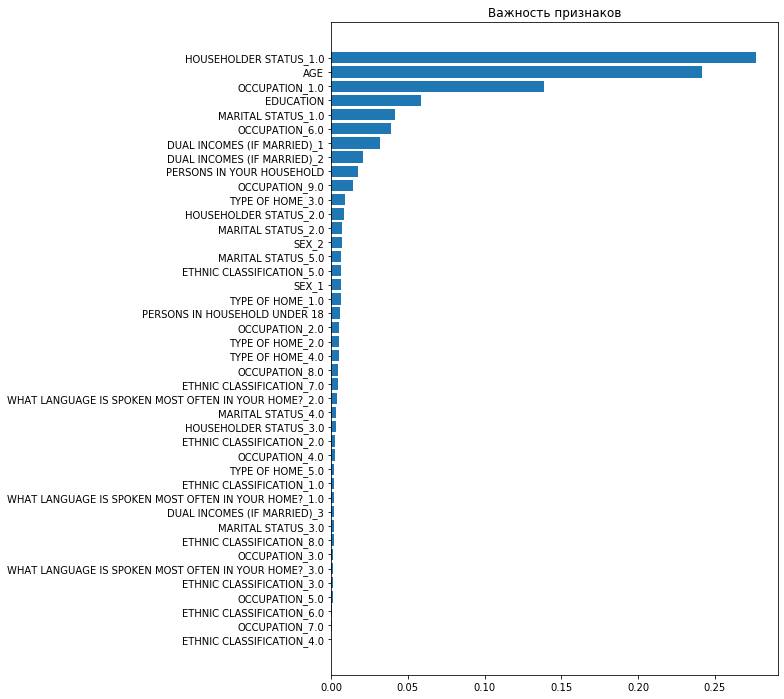

In [105]:
feature_importance = best_clf.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(len(sorted_idx)) 
plt.rcParams['figure.figsize']= (8,12)
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, X_train.columns[sorted_idx])
plt.title('Важность признаков')
plt.show()

Наибольшей значимостью обладают признаки:
- Имеет ли человек собственный дом;
- Возраст респондента;
- Является ли респондент квалифицированным специалистом / менеджером;
- Образование респондента.

Этот результат соответствует интуиции

### Прогнозирование рода занятости

Целевая переменная (род занятости) - категориальная, прогнозирование рода занятости рассматривается как задача многоклассовой классификации.

In [106]:
target_feature = 'OCCUPATION'

Все пропущенные значения исключены.

In [107]:
df_cleared = df.dropna()

In [130]:
oh_encoder = OneHotEncoder(sparse=False)

categorical_cols.remove(target_feature)

encoded_categorical_columns = pd.DataFrame(oh_encoder.fit_transform(df_cleared[categorical_cols]), 
                                           columns=oh_encoder.get_feature_names(categorical_cols))
df_ohe = pd.concat([df_cleared.reset_index().drop(['index'], axis=1).drop(categorical_cols, axis=1), 
                    encoded_categorical_columns], axis=1)

In [131]:
X = df_ohe.drop([target_feature], axis=1)
y = df_ohe[target_feature]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [133]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

На этапе выбора моделей наилучший результат дал градиентный бустинг для задачи классификации (GradientBoostingClassifier). 
Поэтому шкалирование данных не требуется. Также использование бустинга позволяет не убирать сильно скоррелированные признаки.

In [134]:
gbс_model = GradientBoostingClassifier()

В качестве метрики для задачи многоклассовой классификации выбрана метрика 'ROC-AUC' с параметрами 'ovr' и 'weighted'. Параметр 'ovr' вычисляет ROC-AUC каждого класса в сравнении с остальными. Из-за несбалансированности классов целевой переменной использован параметр 'weighted'.

In [135]:
parameters = {
    "n_estimators":list(range(10,101,40)),
    "max_depth":[3,5,7,9],
    "learning_rate":[0.1,0.5,1,10]
}
clf = GridSearchCV(gbс_model, param_grid = parameters, scoring='roc_auc_ovr_weighted', cv = skf, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)
print("Модель с наилучшими параметрами:\n", best_clf.best_estimator_)
print('ROC-AUC на кросс-валидации для всех классов: %.5f' % best_clf.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 16.0min finished


Модель с наилучшими параметрами:
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
ROC-AUC на кросс-валидации для всех классов: 0.85420


In [136]:
print("ROC-AUC на отложенной выборке: %.5f" % roc_auc_score(y_test, best_clf.predict_proba(X_test), average='weighted', multi_class='ovr'))

ROC-AUC на отложенной выборке: 0.85272


Метрика ROC-AUC показывает, что модель градиентного бустинга дает неплохой результат как на обучающей, так и на отложенной выборке.


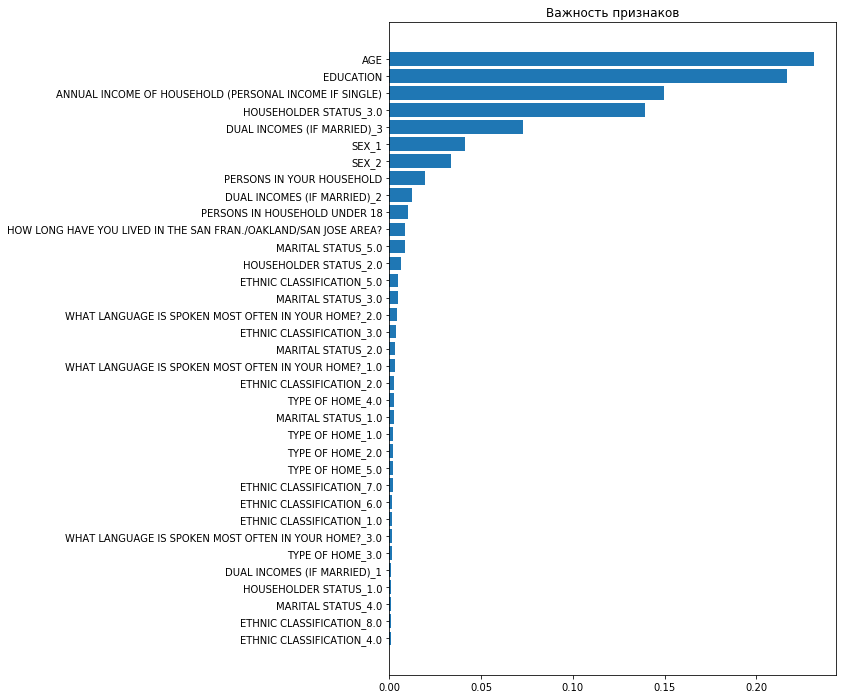

In [137]:
feature_importance = best_clf.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(len(sorted_idx)) 
plt.rcParams['figure.figsize']= (8,12)
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, X_train.columns[sorted_idx])
plt.title('Важность признаков')
plt.show()

Наибольшей значимостью для определения рода занятости обладают признаки:
- Возраст респондента;
- Образование респондента;
- Доход семьи;
- Живет ли респондент с родителями.